# Cleaning and Arranging the data

In [1]:
import argparse
from collections import defaultdict, Counter
import cv2
from fuzzywuzzy import fuzz
from itertools import combinations # not mandatory
import imutils
from imutils import build_montages, paths
import os
import matplotlib.pyplot as plt
import networkx as nx
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import re
import seaborn as sns
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder
import string
# import tensorflow as tf
# from tensorflow.keras import layers, models

### Define useful functions for cleaning the data

In [2]:
def remove_parentheses(string):
    pattern = r'\([^()]*\)'  # Matches "(...)" pattern
    while re.search(pattern, string):
        string = re.sub(pattern, '', string)
    return string.strip()

def format_ingredients(string):
    string = string.replace('.', '')  # Remove periods
    string = re.sub(r'\s*,\s*', ',', string)  # Remove spaces after commas
    ingredients_list = string.split(',')  # Split by comma
    formatted_ingredients = [ingredient.strip() for ingredient in ingredients_list]  # Remove leading/trailing spaces for each ingredient
    return ', '.join(formatted_ingredients)  # Join formatted ingredients with commas

def clean_text_values(df):
    text_columns = df.select_dtypes(exclude=[np.number]).columns
    for column in text_columns:
        if column == 'category':
            continue
        df[column].fillna('NA', inplace=True)
        df[column] = df[column].map(str.lower)
        if column == 'ingredients':
            df[column] = df[column].apply(remove_parentheses)
            df[column] = df[column].apply(format_ingredients)
        if column == 'household_serving_fulltext':
            df[column] = df[column].map(lambda x: re.sub('[^a-z]+', '', x))
    return df

In [3]:
food_train = pd.read_csv('data/food_train.csv')
food_test = pd.read_csv('data/food_test.csv')
food_nutrients = pd.read_csv('data/food_nutrients.csv')
nutrients_names = pd.read_csv('data/nutrients.csv')

In [4]:
clean_text_values(food_train)
nutrients = pd.merge(food_nutrients, nutrients_names, how='left',on='nutrient_id')
pivoted_nutrients = pd.pivot_table(nutrients, values='amount', index='idx', columns='name')
data = pd.merge(food_train, pivoted_nutrients, how='left', on='idx')

#### remove columns with > 0.8 nulls

In [5]:
threshold = 0.8 * len(data)
data.dropna(axis=1, thresh=threshold, inplace=True)

#### split the data into 0.8 train
#### we will also split the 0.8 train into 2 0.4 for feature eng and model tuning

In [6]:
X = data.loc[:,data.columns != 'category']
y = data.loc[:,['idx','category']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_fe, X_mt, y_fe, y_mt = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

#### concat for eda

In [7]:
X_fe_w_cat = pd.merge(X_fe, y_fe, how="left", on='idx')
X_fe_w_cat.head()

,idx,brand,description,ingredients,serving_size,serving_size_unit,household_serving_fulltext,"Calcium, Ca","Carbohydrate, by difference",Cholesterol,Energy,"Fatty acids, total saturated","Fatty acids, total trans","Fiber, total dietary","Iron, Fe",Protein,"Sodium, Na","Sugars, total including NLEA",Total lipid (fat),category
0,27036,nabisco biscuit company,"nabisco, chips ahoy!, crunchy cookies, chocola...","unbleached enriched flour, sugar, palm oil, se...",30.0,g,cookies,0.0,63.33,0.0,533.0,15.00,0.0,3.3,2.40,3.33,317.0,33.33,26.67,cookies_biscuits
1,8207,"rb. confections, lc.","shop n save, cherry sour","sugar, corn syrup, modified food starch, fumar...",41.0,g,pcs,0.0,90.24,0.0,366.0,0.00,NaN,0.0,0.00,0.00,0.0,68.29,0.00,candy
2,11002,"g. debbas chocolatier, inc.","target, mini chocolate chip cookies","chocolate chip cookie, confectioner's coating,...",31.0,g,cookies,65.0,61.29,16.0,516.0,19.35,0.0,3.2,2.32,6.45,32.0,45.16,29.03,cookies_biscuits
3,8033,ferrara candy company,"brach's, spiced jelly bird eggs","sugar, corn syrup modified food starch, cornst...",41.0,g,pieces,0.0,90.24,0.0,366.0,0.00,0.0,0.0,0.00,0.00,24.0,68.29,0.00,candy
4,12321,snak club,peach rings,"product contains: corn syrup, sugar, corn star...",40.0,g,piecesabout,NaN,92.50,0.0,400.0,0.00,0.0,0.0,NaN,2.50,25.0,47.50,0.00,candy


### Enums

In [8]:
CANDY = 'candy'
COOKIES = 'cookies_biscuits'
CAKES = 'cakes_cupcakes_snack_cakes'
CHIPS_PRETZELS = 'chips_pretzels_snacks'
CHOCOLATE = 'chocolate'
POPCORN_PEANUTS = 'popcorn_peanuts_seeds_related_snacks'

### Select by Category

In [9]:
def data_by_category(df, category):
    return df[df['category'] == category]

In [10]:
def better_name(df, col_name):
    df[col_name] = df[col_name].map(lambda x: str(x).translate(str.maketrans('', '', string.punctuation)))
    return(df)

# Part 1 - Feature Engineering
# 'brand' column Research & Treatment

### Find the TOP 10 Brands in each category

We will look over each category and find it's top 10 common brands. After that we will change the brand column and make sure that just the selected top 10 (from each category) brands will stay the same and all the other will sign as unbranded.
We will emphasize that 'not a branded item' will not be counted as part of the top 10!

In [11]:
def top_x_brands_by_category(df, category, x):
    df_by_category = df[df['category'] == category]
    return df_by_category.groupby('brand').size().sort_values(ascending=False).head(x)

def select_only_the_top_brand(df, x):
    better_name(df, 'brand')
    top_brand_dict={'candy': top_x_brands_by_category(df, CANDY, x).index.tolist(),
                   'cookies': top_x_brands_by_category(df, COOKIES, x).index.tolist(),
                   'cakes': top_x_brands_by_category(df, CAKES, x).index.tolist(),
                   'chips_pretzels': top_x_brands_by_category(df, CHIPS_PRETZELS, x).index.tolist(),
                   'chocolate': top_x_brands_by_category(df, CHOCOLATE, x).index.tolist(),
                   'popcorn_peanuts': top_x_brands_by_category(df, POPCORN_PEANUTS, x).index.tolist()}
    df['brand'].fillna('unbranded',inplace=True)
    brands_list = []
    for key, value in top_brand_dict.items():
        if 'not a branded item' in value:
            value.remove('not a branded item')
        brands_list.extend(value)  
    df['brand'] = df['brand'].map(lambda x: x if x in brands_list else 'unbranded')
    return df

In [12]:
select_only_the_top_brand(X_fe_w_cat, 10)

,idx,brand,description,ingredients,serving_size,serving_size_unit,household_serving_fulltext,"Calcium, Ca","Carbohydrate, by difference",Cholesterol,Energy,"Fatty acids, total saturated","Fatty acids, total trans","Fiber, total dietary","Iron, Fe",Protein,"Sodium, Na","Sugars, total including NLEA",Total lipid (fat),category
0,27036,nabisco biscuit company,"nabisco, chips ahoy!, crunchy cookies, chocola...","unbleached enriched flour, sugar, palm oil, se...",30.0,g,cookies,0.0,63.33,0.0,533.0,15.00,0.0,3.3,2.40,3.33,317.0,33.33,26.67,cookies_biscuits
1,8207,unbranded,"shop n save, cherry sour","sugar, corn syrup, modified food starch, fumar...",41.0,g,pcs,0.0,90.24,0.0,366.0,0.00,NaN,0.0,0.00,0.00,0.0,68.29,0.00,candy
2,11002,unbranded,"target, mini chocolate chip cookies","chocolate chip cookie, confectioner's coating,...",31.0,g,cookies,65.0,61.29,16.0,516.0,19.35,0.0,3.2,2.32,6.45,32.0,45.16,29.03,cookies_biscuits
3,8033,ferrara candy company,"brach's, spiced jelly bird eggs","sugar, corn syrup modified food starch, cornst...",41.0,g,pieces,0.0,90.24,0.0,366.0,0.00,0.0,0.0,0.00,0.00,24.0,68.29,0.00,candy
4,12321,unbranded,peach rings,"product contains: corn syrup, sugar, corn star...",40.0,g,piecesabout,NaN,92.50,0.0,400.0,0.00,0.0,0.0,NaN,2.50,25.0,47.50,0.00,candy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12695,23741,unbranded,belgian crunch dark chocolate bar,"dark chocolate, mint inclusions",57.0,g,bar,35.0,52.63,NaN,526.0,17.54,NaN,7.0,NaN,5.26,0.0,45.61,29.82,chocolate
12696,16647,unbranded,cake bar,cake bars with cocoa filling ingredients: coco...,30.0,g,piece,0.0,53.33,50.0,400.0,8.33,0.0,3.3,6.00,6.67,100.0,33.33,20.00,cookies_biscuits
12697,15504,unbranded,"the fresh market, bahama breeze","dried papaya, dried kiwi, dried pineapple, roa...",30.0,g,cup,133.0,70.00,0.0,433.0,5.00,0.0,3.3,1.20,3.33,100.0,50.00,16.67,popcorn_peanuts_seeds_related_snacks
12698,29291,raleys,stick pretzels,"enriched wheat flour, salt, vegetable oil, cor...",28.0,g,onz,0.0,82.14,0.0,393.0,0.00,0.0,3.6,6.43,10.71,1357.0,3.57,3.57,chips_pretzels_snacks


### Top 10 words in each column in the data per category
Now we will find the most 10 common words in each column: 'description', 'ingredients' and 'household' per category. That will help us understand which words are represent and imply each category.

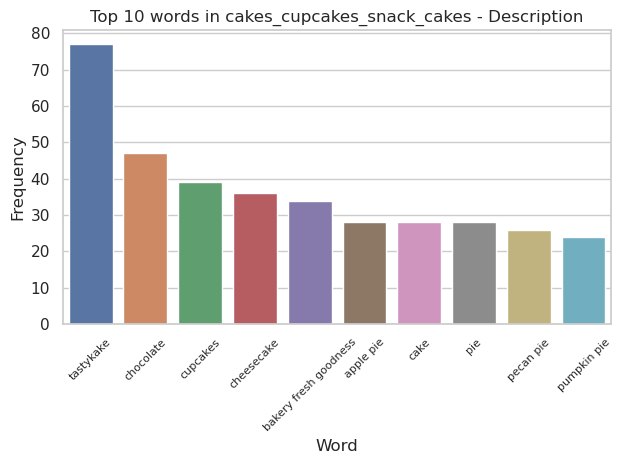

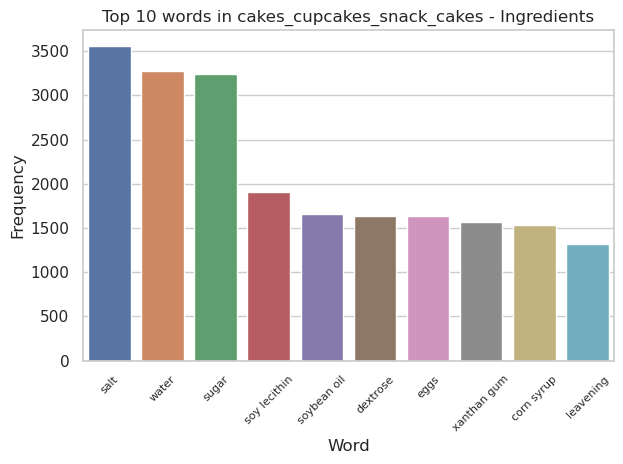

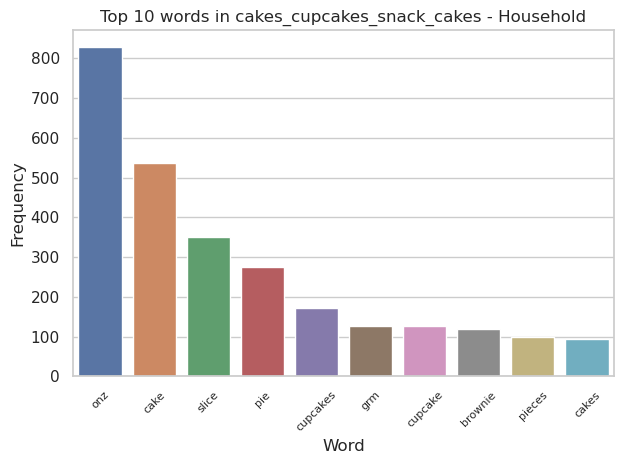

-The Top 10 most common words in "cakes_cupcakes_snack_cakes" category in "description" column are: 
('tastykake', 'chocolate', 'cupcakes', 'cheesecake', 'bakery fresh goodness', 'apple pie', 'cake', 'pie', 'pecan pie', 'pumpkin pie')

-The Top 10 most common words in "cakes_cupcakes_snack_cakes" category in "ingredients" column are: 
('salt', 'water', 'sugar', 'soy lecithin', 'soybean oil', 'dextrose', 'eggs', 'xanthan gum', 'corn syrup', 'leavening')

-The Top 10 most common words in "cakes_cupcakes_snack_cakes" category in "household" column are: 
('onz', 'cake', 'slice', 'pie', 'cupcakes', 'grm', 'cupcake', 'brownie', 'pieces', 'cakes')



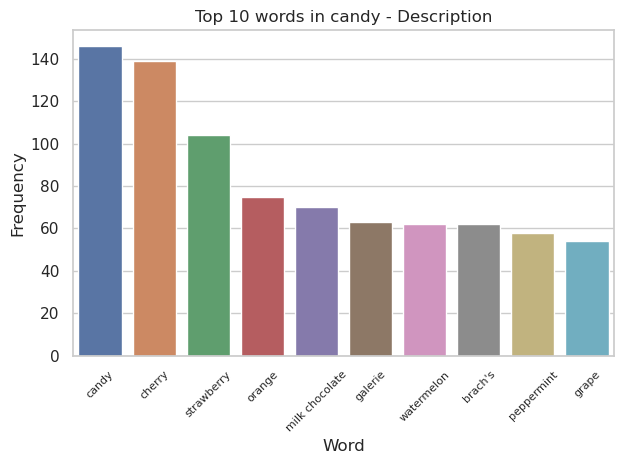

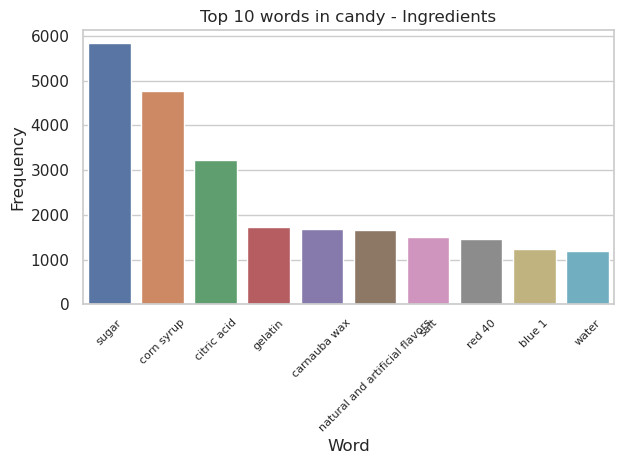

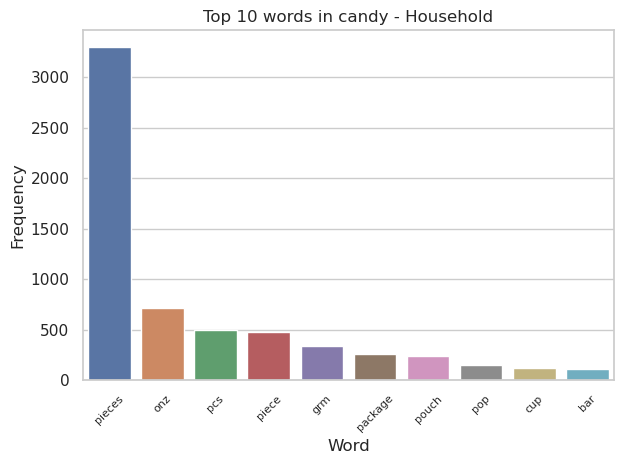

-The Top 10 most common words in "candy" category in "description" column are: 
('candy', 'cherry', 'strawberry', 'orange', 'milk chocolate', 'galerie', 'watermelon', "brach's", 'peppermint', 'grape')

-The Top 10 most common words in "candy" category in "ingredients" column are: 
('sugar', 'corn syrup', 'citric acid', 'gelatin', 'carnauba wax', 'natural and artificial flavors', 'salt', 'red 40', 'blue 1', 'water')

-The Top 10 most common words in "candy" category in "household" column are: 
('pieces', 'onz', 'pcs', 'piece', 'grm', 'package', 'pouch', 'pop', 'cup', 'bar')



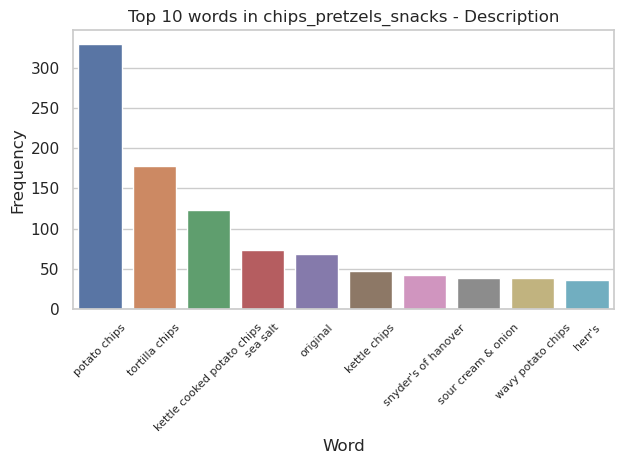

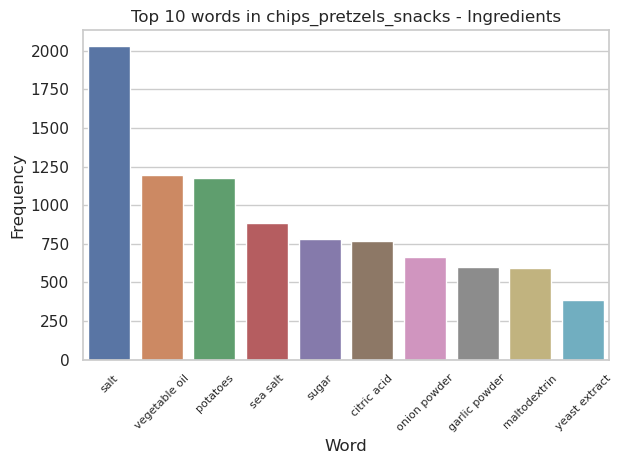

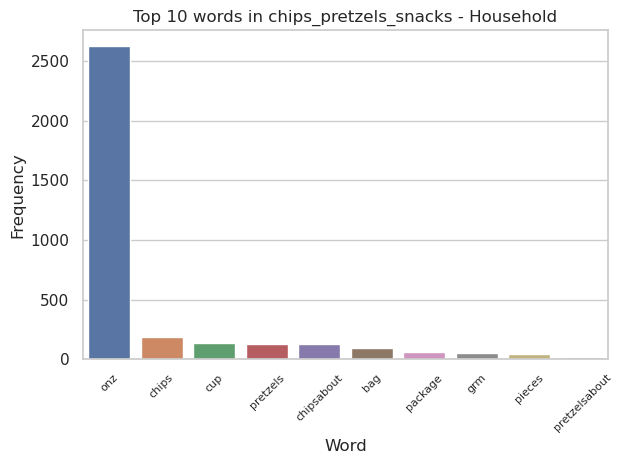

-The Top 10 most common words in "chips_pretzels_snacks" category in "description" column are: 
('potato chips', 'tortilla chips', 'kettle cooked potato chips', 'sea salt', 'original', 'kettle chips', "snyder's of hanover", 'sour cream & onion', 'wavy potato chips', "herr's")

-The Top 10 most common words in "chips_pretzels_snacks" category in "ingredients" column are: 
('salt', 'vegetable oil', 'potatoes', 'sea salt', 'sugar', 'citric acid', 'onion powder', 'garlic powder', 'maltodextrin', 'yeast extract')

-The Top 10 most common words in "chips_pretzels_snacks" category in "household" column are: 
('onz', 'chips', 'cup', 'pretzels', 'chipsabout', 'bag', 'package', 'grm', 'pieces', 'pretzelsabout')



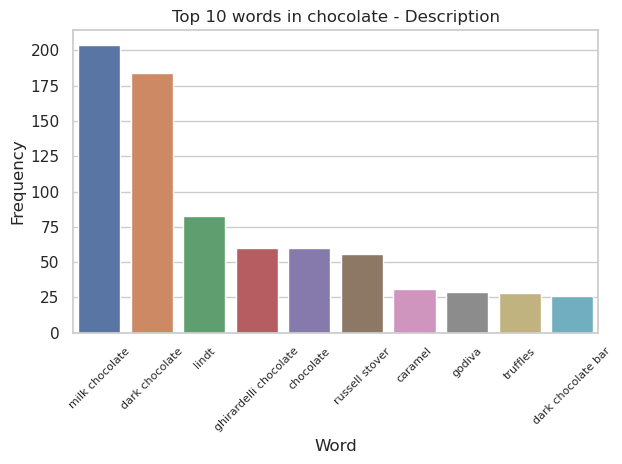

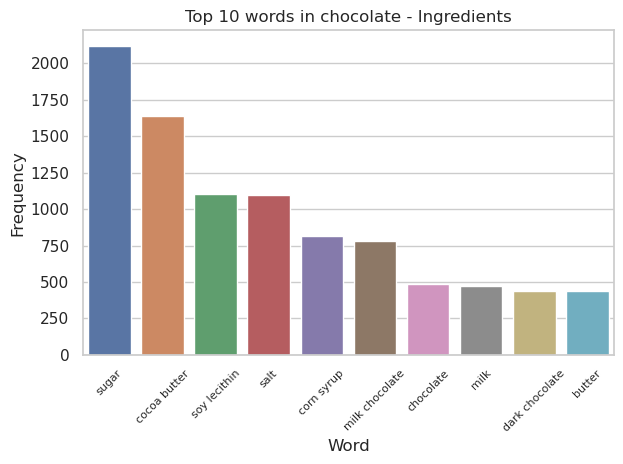

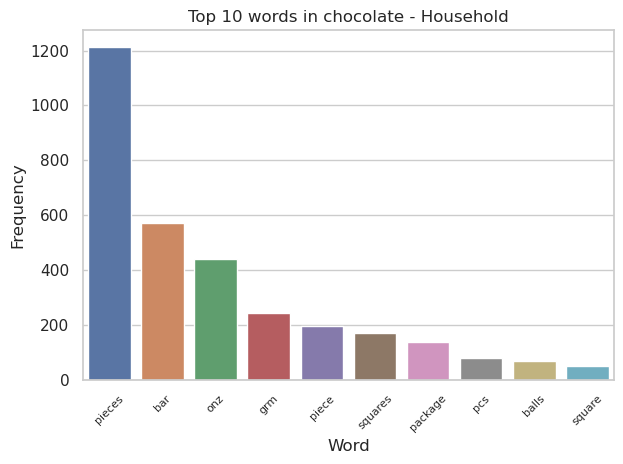

-The Top 10 most common words in "chocolate" category in "description" column are: 
('milk chocolate', 'dark chocolate', 'lindt', 'ghirardelli chocolate', 'chocolate', 'russell stover', 'caramel', 'godiva', 'truffles', 'dark chocolate bar')

-The Top 10 most common words in "chocolate" category in "ingredients" column are: 
('sugar', 'cocoa butter', 'soy lecithin', 'salt', 'corn syrup', 'milk chocolate', 'chocolate', 'milk', 'dark chocolate', 'butter')

-The Top 10 most common words in "chocolate" category in "household" column are: 
('pieces', 'bar', 'onz', 'grm', 'piece', 'squares', 'package', 'pcs', 'balls', 'square')



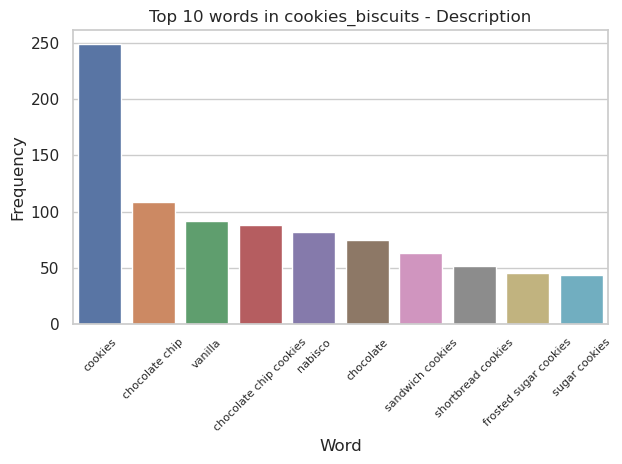

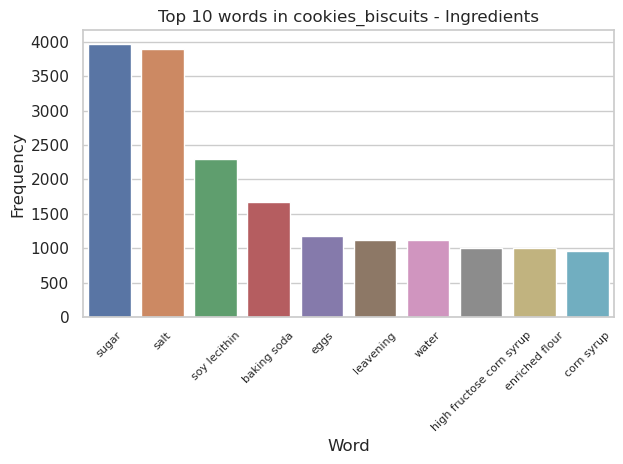

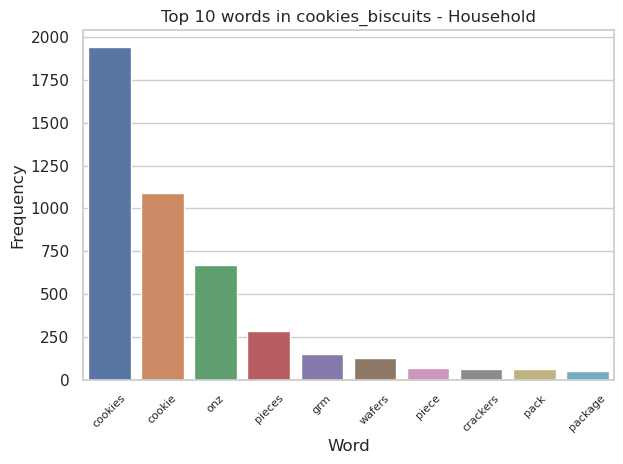

-The Top 10 most common words in "cookies_biscuits" category in "description" column are: 
('cookies', 'chocolate chip', 'vanilla', 'chocolate chip cookies', 'nabisco', 'chocolate', 'sandwich cookies', 'shortbread cookies', 'frosted sugar cookies', 'sugar cookies')

-The Top 10 most common words in "cookies_biscuits" category in "ingredients" column are: 
('sugar', 'salt', 'soy lecithin', 'baking soda', 'eggs', 'leavening', 'water', 'high fructose corn syrup', 'enriched flour', 'corn syrup')

-The Top 10 most common words in "cookies_biscuits" category in "household" column are: 
('cookies', 'cookie', 'onz', 'pieces', 'grm', 'wafers', 'piece', 'crackers', 'pack', 'package')



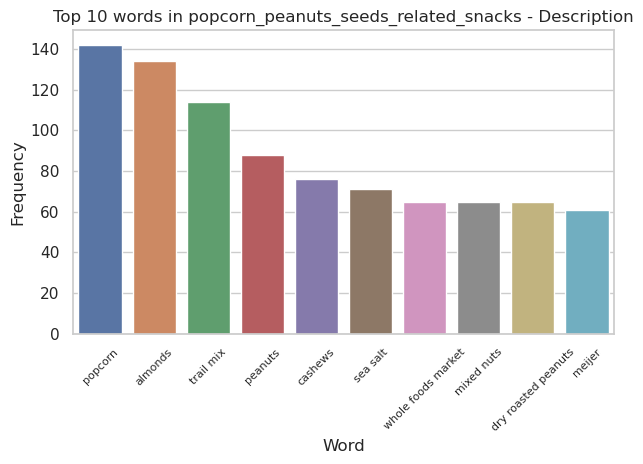

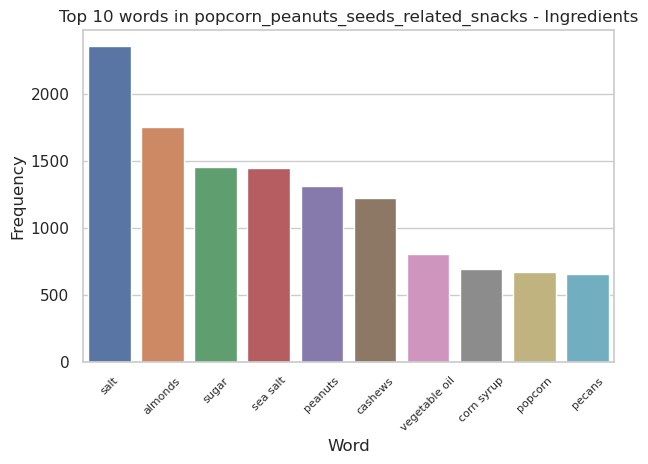

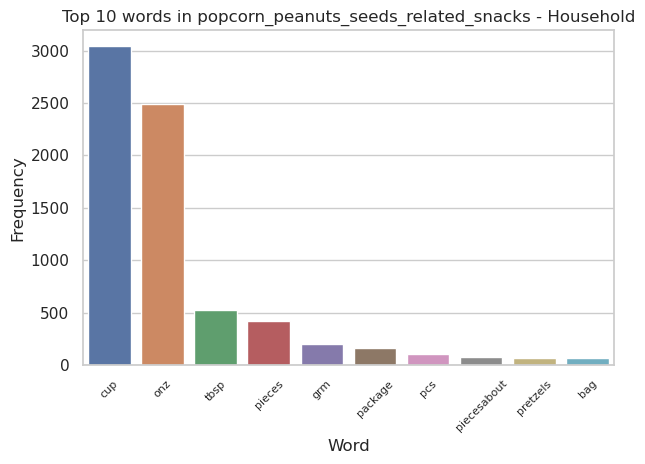

-The Top 10 most common words in "popcorn_peanuts_seeds_related_snacks" category in "description" column are: 
('popcorn', 'almonds', 'trail mix', 'peanuts', 'cashews', 'sea salt', 'whole foods market', 'mixed nuts', 'dry roasted peanuts', 'meijer')

-The Top 10 most common words in "popcorn_peanuts_seeds_related_snacks" category in "ingredients" column are: 
('salt', 'almonds', 'sugar', 'sea salt', 'peanuts', 'cashews', 'vegetable oil', 'corn syrup', 'popcorn', 'pecans')

-The Top 10 most common words in "popcorn_peanuts_seeds_related_snacks" category in "household" column are: 
('cup', 'onz', 'tbsp', 'pieces', 'grm', 'package', 'pcs', 'piecesabout', 'pretzels', 'bag')



In [13]:
# Set Seaborn theme
sns.set_theme(style="whitegrid")

def get_most_popular_words(column):
    text = ', '.join(column.values)
    tokens = [word.strip() for word in text.split(',')]
    stop_words = set(stopwords.words('english'))
    tokens = [word.lower() for word in tokens if word.lower() not in stop_words]
    word_counts = Counter(tokens)
    return word_counts

category_words = {}

for category, group in data.groupby('category'):
    category_words[category] = {
        'description': Counter(),
        'ingredients': Counter(),
        'household' : Counter()
    }

    for _, row in group.iterrows():
        description_word_counts = get_most_popular_words(pd.Series([row['description']]))
        ingredients_word_counts = get_most_popular_words(pd.Series([row['ingredients']]))
        household_word_counts = get_most_popular_words(pd.Series([row['household_serving_fulltext']]))
        
        category_words[category]['description'] += description_word_counts
        category_words[category]['ingredients'] += ingredients_word_counts
        category_words[category]['household'] += household_word_counts
# Plotting
for category, words in category_words.items():
    # Description Words
    description_word_counts = words['description']
    description_top_words = description_word_counts.most_common(10)
    description_words, description_frequencies = zip(*description_top_words)

    plt.figure()
    plt.title(f"Top 10 words in {category} - Description")
    plt.xlabel("Word")
    plt.ylabel("Frequency")
    sns.barplot(x=list(description_words), y=list(description_frequencies))
    plt.xticks(rotation=45, fontsize=8)
    plt.tight_layout()
    plt.show()

    # Ingredients Words
    ingredients_word_counts = words['ingredients']
    ingredients_top_words = ingredients_word_counts.most_common(10)
    ingredients_words, ingredients_frequencies = zip(*ingredients_top_words)

    plt.figure()
    plt.title(f"Top 10 words in {category} - Ingredients")
    plt.xlabel("Word")
    plt.ylabel("Frequency")
    sns.barplot(x=list(ingredients_words), y=list(ingredients_frequencies))
    plt.xticks(rotation=45, fontsize=8)
    plt.tight_layout()
    plt.show()
    
    # household Words
    household_word_counts = words['household']
    household_top_words = household_word_counts.most_common(10)
    household_words, household_frequencies = zip(*household_top_words)

    plt.figure()
    plt.title(f"Top 10 words in {category} - Household")
    plt.xlabel("Word")
    plt.ylabel("Frequency")
    sns.barplot(x=list(household_words), y=list(household_frequencies))
    plt.xticks(rotation=45, fontsize=8)
    plt.tight_layout()
    plt.show()
    
    print(f'-The Top 10 most common words in "{category}" category in "description" column are: \n{description_words}\n')
    print(f'-The Top 10 most common words in "{category}" category in "ingredients" column are: \n{ingredients_words}\n')
    print(f'-The Top 10 most common words in "{category}" category in "household" column are: \n{household_words}\n')

### Most common ingredients/description/household across categories


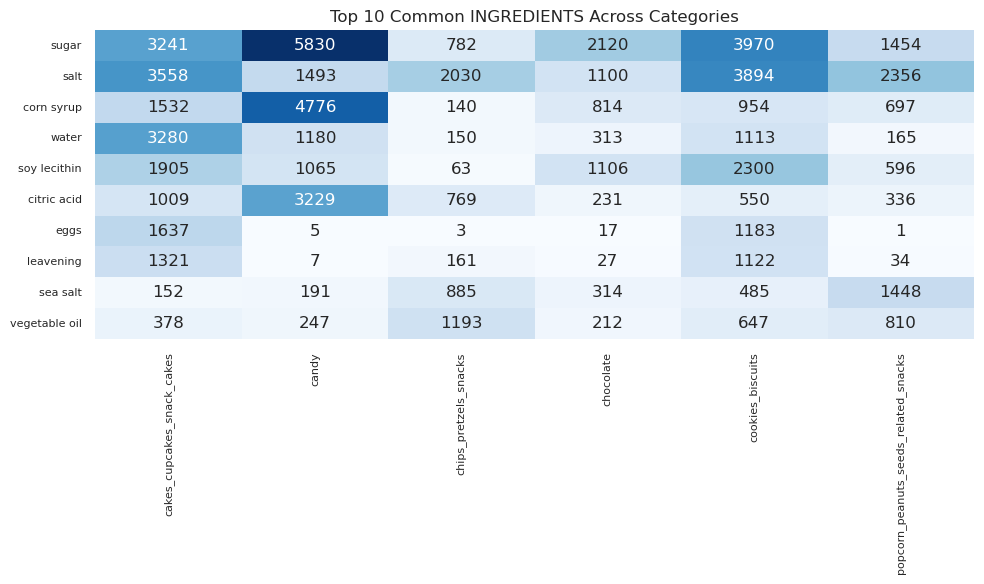

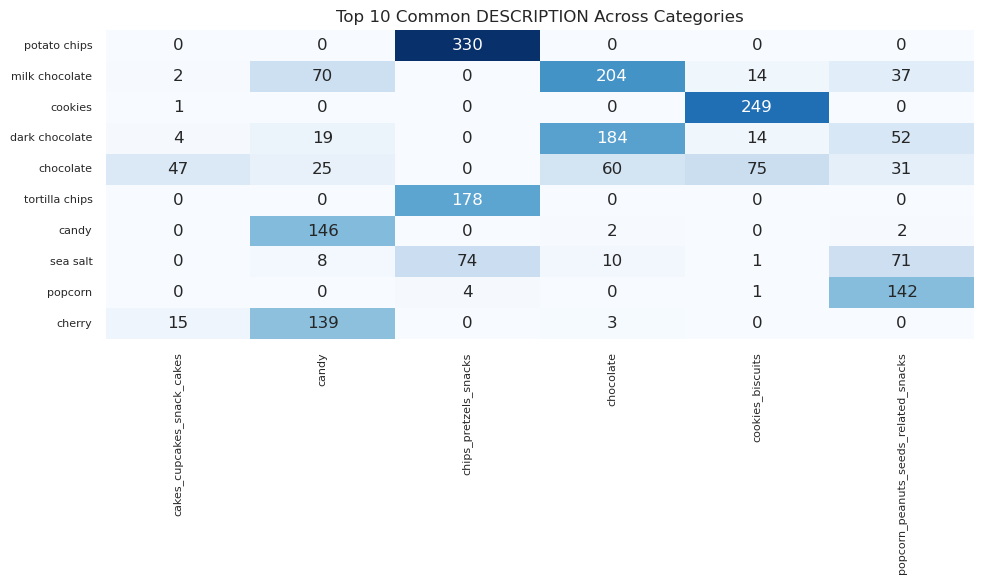

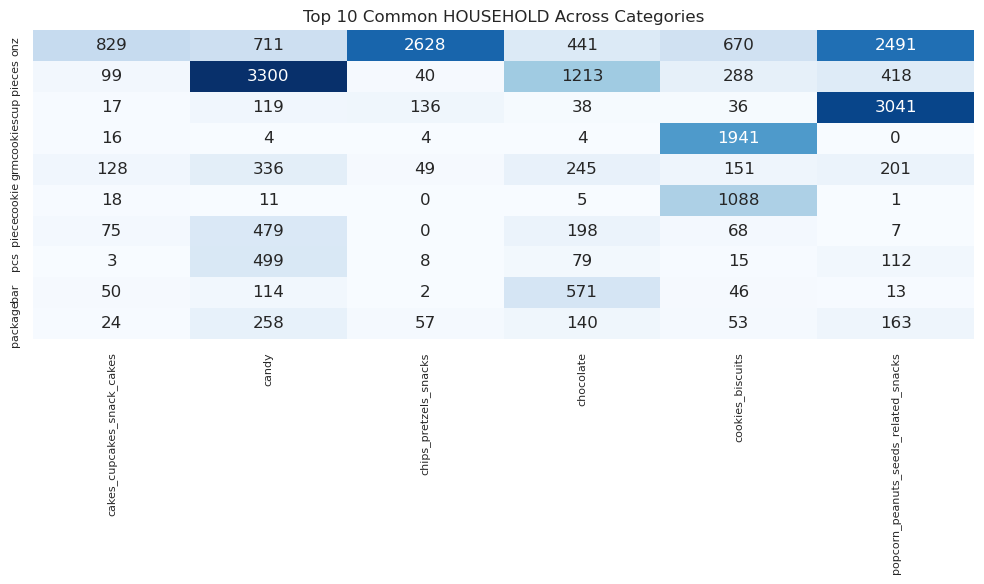

In [14]:
l = ['ingredients', 'description', 'household']
for col in l:
    # Find top common ingredients across all categories
    common_ingredients_counter = Counter()
    for words in category_words.values():
        common_ingredients_counter += Counter(dict(words[col].most_common(10)))

    # Select top 10 common ingredients
    top_common_ingredients = dict(common_ingredients_counter.most_common(10))
    categories = list(category_words.keys())

    # Prepare data for the plot
    plot_data = []
    for ingredient, count in top_common_ingredients.items():
        row = []
        for category in categories:
            row.append(category_words[category][col][ingredient])
        plot_data.append(row)

    # Plotting
    plt.figure(figsize=(10, 6))  # Adjust the figure size as desired
    plt.title(f"Top 10 Common {col.upper()} Across Categories")
    plt.xlabel("Category")
    plt.ylabel(col.upper())
    sns.heatmap(plot_data, cmap="Blues", annot=True, fmt='d', xticklabels=categories, yticklabels=list(top_common_ingredients.keys()), cbar=False)
    plt.xticks(fontsize=8)  # Adjust the x-axis label font size as desired
    plt.yticks(fontsize=8)  # Adjust the y-axis label font size as desired
    plt.tight_layout()
    plt.show()

We will use the results above to select indicative words for each category in each column.

# 'description' column Research & Treatment

In [15]:
def extract_description(data):
    words_of_cake = ['tastykake', 'cupcakes', 'cheezecake', 'bakery fresh goodness', 'apple pie', 'pie', 'pecan pie', 
                     'pumpkin pie', 'cake', 'cakes', 'cupcake', 'coffeecake', 'brownie', 'brownies', 'slice', 'sliced', 
                     'torte', 'pies', 'donut', 'donuts', 'bakery']
    words_of_candys = ['candy', 'candies', 'gummy', 'gummi', 'gummies', 'twist', 'stick', 'marshmallow', 'marshmallows',
                       'jelly', 'snacks', "sweet's",  "brach's", 'cherry', 'strawberry', 'orange', 'watermelon', 
                       'peppermint', 'grape']
    words_of_chips_pretzels = ['potato chips', 'tortilla chips', 'kettle cooked potato chips', 'sea salt', 'kettle chips', 
                               "snyder's of hanover", 'sour cream & onion', 'wavy potato chips', "herr's", 'chips', 'chip', 
                               'tortilla', 'crisps', 'crisp', 'potato', 'pretzel', 'pretzels', 'fries', 'corn']
    words_of_chocolate = ['dark chocolate', 'lindt', 'ghirardelli chocolate', 'russell stover', 'godiva', 'truffles', 
                          'dark chocolate bar', 'cocoa', 'praline', 'toffee', 'belgian', 'dark', 'truffle', 'chocolates']
    words_of_cookie = ['cookie', 'cookies', 'chocolate chip', 'chocolate chip cookies', 'sandwich cookies', 
                       'shortbread cookies', 'frosted sugar cookies', 'sugar cookies''crackers', 'frosted', 'wafer', 
                       'cracker', 'biscuit', 'macaroon', 'waffle']
    words_of_popcorn_peanuts = ['popcorn', 'almond', 'almonds', 'trail mix', 'peanuts', 'mixed nuts', 
                                'dry roasted peanuts','cashews', 'kernel', 'shell', 'pecan']
  
    mat = np.full((len(data), 6), False, dtype=bool)
  
    for i in range(0,len(data)):
        mat[i,0] = any(word in str(data[i]) for word in words_of_cake)
        mat[i,1] = any(word in str(data[i]) for word in words_of_candys)
        mat[i,2] = any(word in str(data[i]) for word in words_of_chips_pretzels)
        mat[i,3] = any(word in str(data[i]) for word in words_of_chocolate)
        mat[i,4] = any(word in str(data[i]) for word in words_of_cookie)
        mat[i,5] = any(word in str(data[i]) for word in words_of_popcorn_peanuts)
    
    headers = ["des_cake_indication", "des_candy_indication", "des_chips_pretzels_indication", "des_chocolate_indication", 
               "des_cookie_indication", "des_popcorn_peanuts_indication"]
    df = pd.DataFrame(mat)
    df.columns = headers
    return(df)

indicative_data = extract_description(data["description"])
for col in indicative_data.columns:
    data[col] = indicative_data[col]
    
data.head()

,idx,brand,description,ingredients,serving_size,serving_size_unit,household_serving_fulltext,category,"Calcium, Ca","Carbohydrate, by difference",...,Protein,"Sodium, Na","Sugars, total including NLEA",Total lipid (fat),des_cake_indication,des_candy_indication,des_chips_pretzels_indication,des_chocolate_indication,des_cookie_indication,des_popcorn_peanuts_indication
0,1,brix chocolate,milk chocolate,"sugar, cocoa butter, whole milk, chocolate liq...",28.0,g,onz,chocolate,143.0,53.57,...,7.14,89.0,42.86,35.71,False,False,False,False,False,False
1,2,target stores,frosted sugar cookies,"sugar, enriched bleached wheat flour, margarin...",38.0,g,cookie,cookies_biscuits,0.0,68.42,...,2.63,276.0,42.11,15.79,False,False,False,False,True,False
2,3,target stores,white frosted mini sugar cookies,"sugar, enriched bleached wheat flour, margarin...",30.0,g,cookies,cookies_biscuits,0.0,70.00,...,3.33,317.0,43.33,15.00,False,False,False,False,True,False
3,4,target stores,chocolaty dipped graham crackers,"sugar, vegetable oil, cocoa powder processed w...",40.0,g,pieces,cookies_biscuits,100.0,67.50,...,5.00,312.0,47.50,22.50,False,False,False,False,True,False
4,5,"ferrero u.s.a., incorporated","ferrero collection, fine assorted confections","semisweet chocolate, sugar, vegetable oils, co...",40.0,g,pieces,chocolate,100.0,47.50,...,7.50,88.0,40.00,42.50,False,False,False,False,False,False


In [16]:
data['des_candy_indication'].sum()

6811

# 'ingredients' column Research & Treatment

[Not sure about the words selection!-Edit]

In [17]:
def extract_ingredients_fulltext(df):
    words_of_cake = ['leavening', 'eggs']
    words_of_candys = ['gelatin', 'carnauba wax', 'red 40', 'blue 1']
    words_of_chips_pretzels = ['potatoes', 'onion powder', 'garlic powder', 'maltodextrin', 'yeast extract']
    words_of_chocolate = ['cocoa butter', 'milk chocolate', 'chocolate', 'milk', 'dark chocolate', 'butter']
    words_of_cookie = ['baking soda', 'enriched flour', 'leavening', 'eggs']
    words_of_popcorn_peanuts = ['almonds', 'peanuts', 'cashews', 'popcorn', 'pecans']
  
    mat = np.full((len(data), 6), False, dtype=bool)
    for i in range(0,len(data)):
        mat[i,0] = df[i] in words_of_cake
        mat[i,1] = df[i] in words_of_candys
        mat[i,2] = df[i] in words_of_chips_pretzels
        mat[i,3] = df[i] in words_of_chocolate
        mat[i,4] = df[i] in words_of_cookie
        mat[i,5] = df[i] in words_of_popcorn_peanuts
    
    headers = ["ingr._cake_indication", "ingr._candy_indication", "ingr._chips_pretzels_indication", "ingr._chocolate_indication", 
               "ingr._cookie_indication", "ingr._popcorn_peanuts_indication"]
    df2 = pd.DataFrame(mat)
    df2.columns = headers
    return(df2)

indicative_data = extract_ingredients_fulltext(data["ingredients"])
for col in indicative_data.columns:
    data[col] = indicative_data[col]
    
data.head()

,idx,brand,description,ingredients,serving_size,serving_size_unit,household_serving_fulltext,category,"Calcium, Ca","Carbohydrate, by difference",...,des_chips_pretzels_indication,des_chocolate_indication,des_cookie_indication,des_popcorn_peanuts_indication,ingr._cake_indication,ingr._candy_indication,ingr._chips_pretzels_indication,ingr._chocolate_indication,ingr._cookie_indication,ingr._popcorn_peanuts_indication
0,1,brix chocolate,milk chocolate,"sugar, cocoa butter, whole milk, chocolate liq...",28.0,g,onz,chocolate,143.0,53.57,...,False,False,False,False,False,False,False,False,False,False
1,2,target stores,frosted sugar cookies,"sugar, enriched bleached wheat flour, margarin...",38.0,g,cookie,cookies_biscuits,0.0,68.42,...,False,False,True,False,False,False,False,False,False,False
2,3,target stores,white frosted mini sugar cookies,"sugar, enriched bleached wheat flour, margarin...",30.0,g,cookies,cookies_biscuits,0.0,70.00,...,False,False,True,False,False,False,False,False,False,False
3,4,target stores,chocolaty dipped graham crackers,"sugar, vegetable oil, cocoa powder processed w...",40.0,g,pieces,cookies_biscuits,100.0,67.50,...,False,False,True,False,False,False,False,False,False,False
4,5,"ferrero u.s.a., incorporated","ferrero collection, fine assorted confections","semisweet chocolate, sugar, vegetable oils, co...",40.0,g,pieces,chocolate,100.0,47.50,...,False,False,False,False,False,False,False,False,False,False


# 'household_serving_fulltext' column Research & Treatment

Notice that 'pretzels' word is common at chips_pretzels category and popcorn_peanuts so we decided not to use it. The same happend with 'chocolate' in some other categories.

In [18]:
def extract_household_serving_fulltext(df):
    words_of_cake = ['cake', 'cakes', 'cupcakes', 'cupcake','brownie', 'pie', 'donut', 'muffin', 'tart', 
                     'torte', 'doughnut','slice', 'pastry', 'bun', 'loaf']
    words_of_candys = ['candies', 'candy','gummies', 'gummy', 'marshmallow', 'pop', 'twist', 'stick','bear']
    words_of_chips_pretzels = ['chip', 'chips', 'fries', 'crisp', 'chipsabout', 'pretzelsabout']
    words_of_chocolate = ['squares', 'square', 'balls', 'ball', 'truffle', 'praline', 'pralines', 'block', 'tablet', 'bar']
    words_of_cookie = ['cookies', 'cookie', 'wafers', 'wafer', 'crackers', 'cracker', 'biscuit', 'macaroon', 'waffle']
    words_of_popcorn_peanuts = ['tbsp', 'kernel', 'popcorn', 'almond', 'shell', 'pecan']
  
    mat = np.full((len(data), 6), False, dtype=bool)
    for i in range(0,len(data)):
        mat[i,0] = df[i] in words_of_cake
        mat[i,1] = df[i] in words_of_candys
        mat[i,2] = df[i] in words_of_chips_pretzels
        mat[i,3] = df[i] in words_of_chocolate
        mat[i,4] = df[i] in words_of_cookie
        mat[i,5] = df[i] in words_of_popcorn_peanuts
    
    headers = ["HSF_cake_indication", "HSF_candy_indication", "HSF_chips_pretzels_indication", "HSF_chocolate_indication", 
               "HSF_cookie_indication", "HSF_popcorn_peanuts_indication"]
    df2 = pd.DataFrame(mat)
    df2.columns = headers
    return(df2)

indicative_data = extract_household_serving_fulltext(data["household_serving_fulltext"])
for col in indicative_data.columns:
    data[col] = indicative_data[col]
    
#data.head()

# 'serving_size' column Research & Treatment

In [19]:
def find_mean_and_median(category, column):
    df = data_by_category(data, category)
    return df[column].mean(), df[column].median()

mean_median_df = {'Category': [CANDY, COOKIES, CAKES, CHIPS_PRETZELS, CHOCOLATE, POPCORN_PEANUTS],
              'Average Size': [find_mean_and_median(CANDY)[0],find_mean_and_median(COOKIES)[0], find_mean_and_median(CAKES)[0],
                               find_mean_and_median(CHIPS_PRETZELS)[0], find_mean_and_median(CHOCOLATE)[0],find_mean_and_median(POPCORN_PEANUTS)[0]],
              'Median Size': [find_mean_and_median(CANDY)[1],find_mean_and_median(COOKIES)[1], find_mean_and_median(CAKES)[1],
                               find_mean_and_median(CHIPS_PRETZELS)[1], find_mean_and_median(CHOCOLATE)[1],find_mean_and_median(POPCORN_PEANUTS)[1]]}
size_df = pd.DataFrame(mean_median_df)

size_df

,Category,Average Size,Median Size
0,candy,32.035885,36.0
1,cookies_biscuits,32.965187,30.0
2,cakes_cupcakes_snack_cakes,75.059577,71.0
3,chips_pretzels_snacks,29.291658,28.0
4,chocolate,38.149377,40.0
5,popcorn_peanuts_seeds_related_snacks,31.666811,30.0


[Add conclutions!]-Edit!

# Nutrients columns Research & Treatment

# Images

# Part 2 - Cross Validation

## CV - HW6 - Need to Change

In [ ]:
def get_ohe(df):
    temp_df = pd.DataFrame(data=ohe.transform(df[['brand',..]]), columns=ohe.get_feature_names_out())
    df.drop(columns=[...], axis=1, inplace=True)
    df = pd.concat([df.reset_index(drop=True), temp_df], axis=1)
    return df

In [ ]:
# x_range = [10, 25, 50, 75, 100, 125, 150, 175, 200]
# performance_metrics = {}
# for p1 in x_range:
#     for p2 in x_range:
#         shoes_train = pd.read_csv('data/shoes_train.csv')
#         shoes_train['price'] = shoes_train['price'].apply(np.log)
#         X = shoes_train.loc[:,shoes_train.columns != 'price']
#         y = shoes_train['price']

#         # Split your dataset into training and validation sets
#         X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#         # Define the range of values for the parameter x
#         x_range = [10, 25, 50, 75, 100, 125, 150]

#         # Initialize a dictionary to store the performance metrics for each x value
#         # performance_metrics = {}

#         # Iterate over each x value and calculate the average performance metric
#         # for x in x_range:
#         # Apply the brand cleaning function with the current x value
#         X_train_cleaned = clear_data(X_train, p1, p2)
#         gb = HistGradientBoostingRegressor(random_state=42)
#         ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
#         ohe.fit(X_train_cleaned[['brand','style','heel_height','material','occasion','country_region_of_manufacture',
#                                                       'color','vintage','location','condition','category']])

#         X_train_cleaned = get_ohe(X_train_cleaned)

#         mse = make_scorer(mean_squared_error)
#         # Perform cross-validation and calculate the performance metric (e.g., accuracy)
#         scores = cross_val_score(gb, X_train_cleaned, y_train, cv=5, scoring=mse, error_score='raise')
#         name = f"{p1}_{p2}"
#         print(f"{name}\n{scores}")
#         avg_score = np.sqrt(np.mean(scores))

#         name = f"{p1}_{p2}"
#         # Store the average performance metric for the current x value
#         performance_metrics[name] = avg_score

# # # Find the best value of x based on the highest average performance metric
# # best_x = max(performance_metrics, key=performance_metrics.get)

# # # Apply the brand cleaning function with the best x value to the entire training set
# # X_train_cleaned = brand_cleaning_function(X_train, best_x)

# # # Train the model using the best x value on the entire training set
# # classifier.fit(X_train_cleaned, y_train)

# # # Apply the brand cleaning function with the best x value to the validation set
# # X_val_cleaned = brand_cleaning_function(X_val, best_x)

# # # Evaluate the performance of the model on the validation set
# # y_val_pred = classifier.predict(X_val_cleaned)
# # val_accuracy = accuracy_score(y_val, y_val_pred)

# # # Print the best x value and the validation accuracy
# # print("Best x value:", best_x)
# # print("Validation accuracy:", val_accuracy)


In [ ]:
#performance_metrics
#best_p = min(performance_metrics, key=performance_metrics.get)
#p = best_p.split('_')
#p1 = int(p[0])
#p2 = int(p[1])

# Part 3 - Models
# Model_1

# Model_2

# Model_3